# Low c-rate aging simulation ORIGINAL Code from ACC Paper

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp

DATA_DIR  = "./data/esoh_V/"
fig_DIR = "./figures/"

# Set Parameters and Expansion Functions

In [2]:
def nmc_volume_change_mohtat(sto):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

In [3]:
parameter_values.search("Li")

Cell cooling surface area [m2]	0.41
Initial plated lithium concentration [mol.m-3]	0.0
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Lithium interstitial reference concentration [mol.m-3]	15.0
Lithium metal partial molar volume [m3.mol-1]	1.3e-05
Typical lithium ion diffusivity [m2.s-1]	5.34e-10
Typical plated lithium concentration [mol.m-3]	1000.0


In [4]:
def split_long_string(title, max_words=None):
    """Get title in a nice format"""
    max_words = max_words or pybamm.settings.max_words_in_line
    words = title.split()
    # Don't split if fits on one line, don't split just for units
    if len(words) <= max_words or words[max_words].startswith("["):
        return title
    else:
        first_line = (" ").join(words[:max_words])
        second_line = (" ").join(words[max_words:])
        return first_line + "\n" + second_line

# Accelerated Simulations Function

In [5]:
def cycle_adaptive_simulation(model, parameter_values, experiment,SOC_0=1, save_at_cycles=None):
    experiment_one_cycle = pybamm.Experiment(
        experiment.operating_conditions_cycles[:1],
        termination=experiment.termination_string,
        cccv_handling=experiment.cccv_handling,
    )
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    c_n_max = parameter_values.evaluate(param.c_n_max)
    c_p_max = parameter_values.evaluate(param.c_p_max)
    n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
                "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            
        }
    )

    sim_ode = pybamm.Simulation(
        model, experiment=experiment_one_cycle, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol0 = sim_ode.solve(initial_soc=SOC_0)
    model = sim_ode.solution.all_models[0]
    cap0 = sol0.summary_variables["Capacity [A.h]"]

    def sol_to_y(sol, loc="end"):
        if loc == "start":
            pos = 0
        elif loc == "end":
            pos = -1
        model = sol.all_models[0]
        n_Li = sol["Total lithium in particles [mol]"].data[pos].flatten()
        Cn = sol["Negative electrode capacity [A.h]"].data[pos].flatten()
        Cp = sol["Positive electrode capacity [A.h]"].data[pos].flatten()
        # y = np.concatenate([n_Li, Cn, Cp])
        y = n_Li
        for var in model.initial_conditions:
            if var.name not in [
                "X-averaged negative particle concentration",
                "X-averaged positive particle concentration",
                "Discharge capacity [A.h]",
            ]:
                value = sol[var.name].data
                if value.ndim == 1:
                    value = value[pos]
                elif value.ndim == 2:
                    value = value[:, pos]
                elif value.ndim == 3:
                    value = value[:, :, pos]
                y = np.concatenate([y, value.flatten()])
        return y

    def y_to_sol(y, esoh_sim, model):
        n_Li = y[0]
        Cn = C_over_eps_n * y[1]
        Cp = C_over_eps_p * y[2]

        esoh_sol = esoh_sim.solve(
            [0],
            inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
        )
        esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
        ics = {}
        x_100 = esoh_sol["x_100"].data[0]
        y_100 = esoh_sol["y_100"].data[0]
        x_0 = esoh_sol["x_0"].data[0]
        y_0 = esoh_sol["y_0"].data[0]
        start = 1
        for var in model.initial_conditions:
            if var.name == "X-averaged negative particle concentration":
                ics[var.name] = ((x_100-x_0)*SOC_0+x_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "X-averaged positive particle concentration":
                ics[var.name] = ((y_100-y_0)*SOC_0+y_0) * np.ones((model.variables[var.name].size, 2))
            elif var.name == "Discharge capacity [A.h]":
                ics[var.name] = np.zeros(1)
            else:
                end = start + model.variables[var.name].size
                ics[var.name] = y[start:end, np.newaxis]
                start = end
        model.set_initial_conditions_from(ics)
        return pybamm.Solution(
            [np.array([0])],
            model.concatenated_initial_conditions.evaluate()[:, np.newaxis],
            model,
            {},
        )

    def dydt(t, y):
        if y[0] < 0 or y[1] < 0 or y[2] < 0:
            return 0 * y

        print(t)
        # Set up based on current value of y
        y_to_sol(
            y,
            esoh_sim,
            sim_ode.op_conds_to_built_models[
                experiment_one_cycle.operating_conditions[0]["electric"]
            ],
        )

        # Simulate one cycle
        sol = sim_ode.solve()

        dy = sol_to_y(sol) - y

        return dy

    if experiment.termination == {}:
        event = None
    else:

        def capacity_cutoff(t, y):
            sol = y_to_sol(y, esoh_sim, model)
            cap = pybamm.make_cycle_solution([sol], esoh_sim, True)[1]["Capacity [A.h]"]
            return cap / cap0 - experiment_one_cycle.termination["capacity"][0] / 100

        capacity_cutoff.terminal = True

    num_cycles = len(experiment.operating_conditions_cycles)
    if save_at_cycles is None:
        t_eval = np.arange(1, num_cycles + 1)
    elif save_at_cycles == -1:
        t_eval = None
    else:
        t_eval = np.arange(1, num_cycles + 1, save_at_cycles)
    y0 = sol_to_y(sol0, loc="start")
    timer = pybamm.Timer()
    sol = solve_ivp(
        dydt,
        [1, num_cycles],
        y0,
        t_eval=t_eval,
        events=capacity_cutoff,
        first_step=10,
        method="RK23",
        atol=1e-2,
        rtol=1e-2,
    )
    time = timer.time()

    all_sumvars = []
    for idx in range(sol.y.shape[1]):
        fullsol = y_to_sol(sol.y[:, idx], esoh_sim, model)
        sumvars = pybamm.make_cycle_solution([fullsol], esoh_sim, True)[1]
        all_sumvars.append(sumvars)

    all_sumvars_dict = {
        key: np.array([sumvars[key] for sumvars in all_sumvars])
        for key in all_sumvars[0].keys()
    }
    all_sumvars_dict["Cycle number"] = sol.t
    
    all_sumvars_dict["cycles evaluated"] = sol.nfev
    all_sumvars_dict["solution time"] = time
    
    return all_sumvars_dict

# Plot Functions

In [6]:
def plot(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    fig, axes = plt.subplots(3,2,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

def plot1(all_sumvars_dict,esoh_data):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    fig, axes = plt.subplots(2,1,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    fig.legend(["Acc Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig
    
def plotc(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        # ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.legend(["Acc Sim"] + ["Reported"], 
    #        loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

# Choose Cell

In [7]:
cell = 4

## Set cell eSOH and cycling parameters 

In [8]:
cell_no = f'{cell:02d}'
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    eps_n_data = 0.6234
    eps_p_data = 0.4542
elif cell_no=='04':
    c_rate_c = '1.5C'
    c_rate_d = '1.5C'
    dis_set = " until 3V"
    eps_n_data = 0.6247
    eps_p_data = 0.4512
elif cell_no=='07':
    c_rate_c = '2C'
    c_rate_d = '2C'
    dis_set = " until 3V"
    eps_n_data = 0.6166
    eps_p_data = 0.4529
elif cell_no=='10':
    c_rate_c = 'C/5'
    c_rate_d = '1.5C'
    dis_set = " until 3V"
    eps_n_data = 0.6250
    eps_p_data = 0.4493
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"
    eps_n_data = 0.6247
    eps_p_data = 0.4544
elif cell_no=='16':
    c_rate_c = 'C/5'
    c_rate_d = '1.5C'
    dis_set = " for 20 min"
    eps_n_data = 0.6243
    eps_p_data = 0.4501
esoh_data =  pd.read_csv(DATA_DIR +'aging_param_cell_'+cell_no+'.csv')  
esoh_data.N.iloc[-1]

328

# Define Experiment and Model

In [9]:
pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *esoh_data.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

# Set Additional Parameter Value and Simulate

In [10]:
parameter_values = get_parameter_values()
parameter_values.update(
    {

        "Positive electrode LAM constant proportional term [s-1]": 8.7864e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.08031e-05,
        "SEI kinetic rate constant [m.s-1]": 1.6297e-15,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Negative electrode porosity": 0.3,
        "Positive electrode porosity": 0.3,
        "Separator porosity": 0.4,
        # "Negative electrode porosity": 0.28,
        # "Positive electrode porosity": 0.28,
        # "Separator porosity": 0.38,
        # "Negative electrode porosity": 0.15,
        # "Positive electrode porosity": 0.15,
        # "Separator porosity": 0.2,
    },
    check_already_exists=False,
)
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [11]:
# fig = plotc(all_sumvars_dict,esoh_data);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_esoh.png')

In [12]:
# afsdfsd

# Normal Simulations

In [13]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long_0 = sim_long.solve(initial_soc=1)
long_sol_output_0 =sol_long_0.summary_variables

2022-05-18 18:17:20,154 - [NOTICE] simulation.solve(855): Cycle 1/328 (37.089 ms elapsed) --------------------
2022-05-18 18:17:20,155 - [NOTICE] simulation.solve(889): Cycle 1/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:17:20,432 - [NOTICE] simulation.solve(889): Cycle 1/328, step 2/4: Rest for 5 min
2022-05-18 18:17:20,556 - [NOTICE] simulation.solve(889): Cycle 1/328, step 3/4: Charge at 1.5C until 4.2V
2022-05-18 18:17:20,843 - [NOTICE] simulation.solve(889): Cycle 1/328, step 4/4: Hold at 4.2V until C/50
2022-05-18 18:17:21,607 - [NOTICE] simulation.solve(977): Capacity is now 5.032 Ah (originally 5.032 Ah, will stop at 2.516 Ah)
2022-05-18 18:17:21,609 - [NOTICE] simulation.solve(855): Cycle 2/328 (1.492 s elapsed) --------------------
2022-05-18 18:17:21,609 - [NOTICE] simulation.solve(889): Cycle 2/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:17:21,821 - [NOTICE] simulation.solve(889): Cycle 2/328, step 2/4: Rest for 5 min
2022-05-18 18:17:21,859 - [NOTIC

In [14]:
parameter_values = get_parameter_values()
parameter_values.update(
    {

        "Positive electrode LAM constant proportional term [s-1]": 8.7864e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.08031e-05,
        "SEI kinetic rate constant [m.s-1]": 1.6297e-15,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Negative electrode porosity": 0.3,
        # "Positive electrode porosity": 0.3,
        # "Separator porosity": 0.4,
        "Negative electrode porosity": 0.28,
        "Positive electrode porosity": 0.28,
        "Separator porosity": 0.38,
        # "Negative electrode porosity": 0.15,
        # "Positive electrode porosity": 0.15,
        # "Separator porosity": 0.2,
    },
    check_already_exists=False,
)
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [15]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long_1 = sim_long.solve(initial_soc=1)
long_sol_output_1 =sol_long_1.summary_variables

2022-05-18 18:20:56,218 - [NOTICE] simulation.solve(855): Cycle 1/328 (37.726 ms elapsed) --------------------
2022-05-18 18:20:56,219 - [NOTICE] simulation.solve(889): Cycle 1/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:20:56,473 - [NOTICE] simulation.solve(889): Cycle 1/328, step 2/4: Rest for 5 min
2022-05-18 18:20:56,602 - [NOTICE] simulation.solve(889): Cycle 1/328, step 3/4: Charge at 1.5C until 4.2V
2022-05-18 18:20:56,848 - [NOTICE] simulation.solve(889): Cycle 1/328, step 4/4: Hold at 4.2V until C/50
2022-05-18 18:20:57,552 - [NOTICE] simulation.solve(977): Capacity is now 5.032 Ah (originally 5.032 Ah, will stop at 2.516 Ah)
2022-05-18 18:20:57,553 - [NOTICE] simulation.solve(855): Cycle 2/328 (1.373 s elapsed) --------------------
2022-05-18 18:20:57,553 - [NOTICE] simulation.solve(889): Cycle 2/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:20:57,707 - [NOTICE] simulation.solve(889): Cycle 2/328, step 2/4: Rest for 5 min
2022-05-18 18:20:57,740 - [NOTIC

In [16]:
parameter_values = get_parameter_values()
parameter_values.update(
    {

        "Positive electrode LAM constant proportional term [s-1]": 8.7864e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.08031e-05,
        "SEI kinetic rate constant [m.s-1]": 1.6297e-15,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        # "Negative electrode porosity": 0.3,
        # "Positive electrode porosity": 0.3,
        # "Separator porosity": 0.4,
        # "Negative electrode porosity": 0.28,
        # "Positive electrode porosity": 0.28,
        # "Separator porosity": 0.38,
        "Negative electrode porosity": 0.15,
        "Positive electrode porosity": 0.15,
        "Separator porosity": 0.2,
    },
    check_already_exists=False,
)
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [17]:
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long_2 = sim_long.solve(initial_soc=1)
long_sol_output_2 =sol_long_2.summary_variables

2022-05-18 18:24:24,452 - [NOTICE] simulation.solve(855): Cycle 1/328 (51.984 ms elapsed) --------------------
2022-05-18 18:24:24,453 - [NOTICE] simulation.solve(889): Cycle 1/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:24:24,702 - [NOTICE] simulation.solve(889): Cycle 1/328, step 2/4: Rest for 5 min
2022-05-18 18:24:24,819 - [NOTICE] simulation.solve(889): Cycle 1/328, step 3/4: Charge at 1.5C until 4.2V
2022-05-18 18:24:25,054 - [NOTICE] simulation.solve(889): Cycle 1/328, step 4/4: Hold at 4.2V until C/50
2022-05-18 18:24:25,864 - [NOTICE] simulation.solve(977): Capacity is now 5.031 Ah (originally 5.031 Ah, will stop at 2.516 Ah)
2022-05-18 18:24:25,865 - [NOTICE] simulation.solve(855): Cycle 2/328 (1.465 s elapsed) --------------------
2022-05-18 18:24:25,865 - [NOTICE] simulation.solve(889): Cycle 2/328, step 1/4: Discharge at 1.5C until 3V
2022-05-18 18:24:26,007 - [NOTICE] simulation.solve(889): Cycle 2/328, step 2/4: Rest for 5 min
2022-05-18 18:24:26,041 - [NOTIC

In [21]:
long_sol_output_0.keys()

dict_keys(['Minimum measured discharge capacity [A.h]', 'Maximum measured discharge capacity [A.h]', 'Measured capacity [A.h]', 'Positive electrode capacity [A.h]', 'Change in positive electrode capacity [A.h]', 'Loss of active material in positive electrode [%]', 'Change in loss of active material in positive electrode [%]', 'Loss of lithium inventory [%]', 'Change in loss of lithium inventory [%]', 'Loss of lithium inventory, including electrolyte [%]', 'Change in loss of lithium inventory, including electrolyte [%]', 'Total lithium [mol]', 'Change in total lithium [mol]', 'Total lithium in electrolyte [mol]', 'Change in total lithium in electrolyte [mol]', 'Total lithium in positive electrode [mol]', 'Change in total lithium in positive electrode [mol]', 'Total lithium in particles [mol]', 'Change in total lithium in particles [mol]', 'Total lithium lost [mol]', 'Change in total lithium lost [mol]', 'Total lithium lost from particles [mol]', 'Change in total lithium lost from partic

In [22]:
def plotc3(all_sumvars_dict,all_sumvars_dict1,all_sumvars_dict2,esoh_data):
    esoh_vars = ["x_100", "y_100","x_0", "y_0", "C_n", "C_p", ]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict[name],"bo")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict[name],"go")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Normal"] + ["10% Comp"] + ["50% Comp"] + ["Reported"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

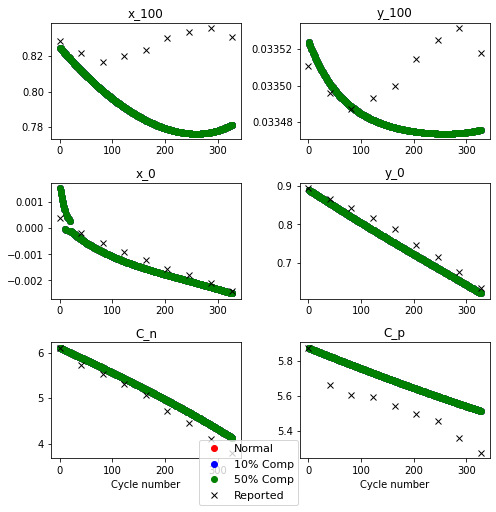

In [23]:
fig = plotc3(long_sol_output_0,long_sol_output_1,long_sol_output_2,esoh_data);
fig.savefig(fig_DIR +'normal_sim_'+cell_no+'highc_comp_esoh_1.png')

In [24]:
for value in long_sol_output_0.keys():
    print(value)

Minimum measured discharge capacity [A.h]
Maximum measured discharge capacity [A.h]
Measured capacity [A.h]
Positive electrode capacity [A.h]
Change in positive electrode capacity [A.h]
Loss of active material in positive electrode [%]
Change in loss of active material in positive electrode [%]
Loss of lithium inventory [%]
Change in loss of lithium inventory [%]
Loss of lithium inventory, including electrolyte [%]
Change in loss of lithium inventory, including electrolyte [%]
Total lithium [mol]
Change in total lithium [mol]
Total lithium in electrolyte [mol]
Change in total lithium in electrolyte [mol]
Total lithium in positive electrode [mol]
Change in total lithium in positive electrode [mol]
Total lithium in particles [mol]
Change in total lithium in particles [mol]
Total lithium lost [mol]
Change in total lithium lost [mol]
Total lithium lost from particles [mol]
Change in total lithium lost from particles [mol]
Total lithium lost from electrolyte [mol]
Change in total lithium lo

In [34]:
def plotc4(all_sumvars_dict,all_sumvars_dict1,all_sumvars_dict2,esoh_data):
    esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]","Loss of active material in negative electrode [%]","Loss of active material in positive electrode [%]","Total capacity lost to side reactions [A.h]","Local ECM resistance [Ohm]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    esoh_data["Loss of active material in negative electrode [%]"]=(1-esoh_data["C_n"]/esoh_data["C_n"][0])*100
    esoh_data["Loss of active material in positive electrode [%]"]=(1-esoh_data["C_p"]/esoh_data["C_p"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(all_sumvars_dict1["Cycle number"],all_sumvars_dict[name],"bo")
        ax.plot(all_sumvars_dict2["Cycle number"],all_sumvars_dict[name],"go")
        if k<4:
            ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Normal"] + ["10% Comp"] + ["50% Comp"] + ["Reported"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.07], ncol=4, fontsize=11)
    fig.tight_layout()
    return fig

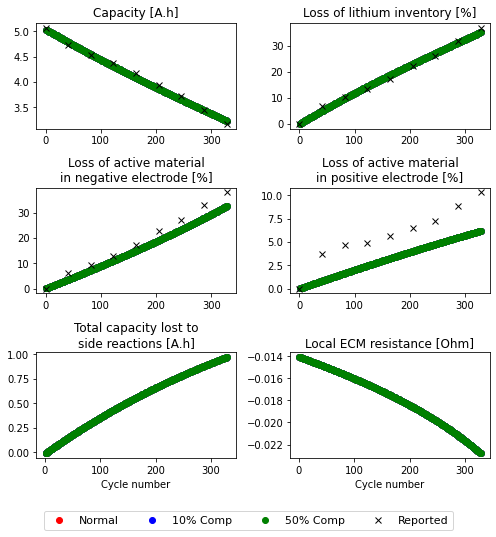

In [35]:
fig = plotc4(long_sol_output_0,long_sol_output_1,long_sol_output_2,esoh_data);
fig.savefig(fig_DIR +'normal_sim_'+cell_no+'highc_comp_esoh_2.png')

In [18]:
asdasd

NameError: name 'asdasd' is not defined

In [ ]:
fig = plotc(long_sol_output,esoh_data);
fig.savefig(fig_DIR +'normal_sim_'+cell_no+'highc_normal_esoh.png')
# fig.savefig(fig_DIR +'normal_sim_'+cell_no+'highc_pressure_esoh.png')
# fig.savefig(fig_DIR +'normal_sim_'+cell_no+'lowc_pressure2_esoh.png')


In [ ]:
dfdsfdsf

## Comparison Plots

In [ ]:
def plot_comp_long(all_sumvars_dict,esoh_data,long_sol_output,n: int = 1):
    esoh_vars = ["x_0", "y_0", "x_100", "y_100", "C_n", "C_p"]
    # esoh_vars = ["Capacity [A.h]", "Loss of lithium inventory [%]",
    #              "Loss of active material in negative electrode [%]",
    #              "Loss of active material in positive electrode [%]"]
    esoh_data['N']=esoh_data['N'].astype(int)
    esoh_data1 = esoh_data
    esoh_data1['N'] = esoh_data1['N']-1
    esoh_data1['N'].iloc[0] =esoh_data1['N'].iloc[0]+1 
    fig, axes = plt.subplots(3,2,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(long_sol_output["Cycle number"],long_sol_output[name],"b.")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
#         ax.scatter(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],color="r")
    #     ax.plot(long_sol.summary_variables[name],"b-")
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    # fig.subplots_adjust(bottom=0.4)
    fig.legend(["Acc Sim"] + ["Long Sim"] + ["Reported"], 
           loc="lower center", ncol=1, fontsize=11)
    fig.tight_layout()

    return fig

def plot1_comp_long(all_sumvars_dict,esoh_data,long_sol_output,n: int = 1):
    esoh_vars = ["Capacity [A.h]","n_Li"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data['N']=esoh_data['N'].astype(int)
    esoh_data1 = esoh_data
    esoh_data1 = esoh_data
    esoh_data1['N'] = esoh_data1['N']-1
    esoh_data1['N'].iloc[0] =esoh_data1['N'].iloc[0]+1 
    fig, axes = plt.subplots(2,1,figsize=(7,9))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"][esoh_data1['N']//n],all_sumvars_dict[name][esoh_data1['N']//n],"ro")
        ax.plot(long_sol_output["Cycle number"][esoh_data1['N']],long_sol_output[name][esoh_data1['N']],"b.")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        ax.set_xlabel("Cycle number")
    ax.legend(["Acc Sim"] + ["Long Sim"] + ["Reported"], 
           loc="upper right", ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

In [ ]:
fig = plot_comp_long(all_sumvars_dict,esoh_data,long_sol_output,1)

In [ ]:
# spm.variables.search("Concentration")

In [ ]:
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = -sol_long['Discharge capacity [A.h]'].entries
Vt = sol_long["Terminal voltage [V]"].entries
exp = 30e6*sol_long["Cell thickness change [m]"].entries
exp_n = 30e6*sol_long["Negative Electrode thickness change [m]"].entries
exp_p = 30e6*sol_long["Positive Electrode thickness change [m]"].entries
ee_p = sol_long["X-averaged positive electrode porosity"].entries
ee_n = sol_long["X-averaged negative electrode porosity"].entries
ee_s = sol_long["X-averaged separator porosity"].entries
j_n = sol_long["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p = sol_long["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

In [ ]:
plt.figure()
plt.plot(-Q,Vt)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
plt.figure()
plt.plot(t,Vt)
# plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Voltage [V]')

In [ ]:
fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1,3,1)
ax1.plot(-Q,exp_n)
ax1.set_xlim(left=0)
ax1.set_xlabel('Q [Ah]')
ax1.set_ylabel('Exp [$\mu$m]')
ax1.set_title('NE')
ax2 = plt.subplot(1,3,2)
ax2.plot(-Q,exp)
ax2.set_xlim(left=0)
ax2.set_xlabel('Q [Ah]')
ax2.set_title('Total')
ax2.set_ylabel('Exp [$\mu$m]')
ax3 = plt.subplot(1,3,3)
ax3.plot(-Q,exp_p)
ax3.set_xlim(left=0)
ax3.set_xlabel('Q [Ah]')
ax3.set_ylabel('Exp [$\mu$m]')
ax3.set_title('PE')
fig.tight_layout()